# Catalog matching
Here we match objects from the RBC to objects in the PAndAS catalogues. We iterate over the entire field.


## Initial startup requirements

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii

In [11]:
# import CATs for testing, will use the entire field when ready
CAT = pickle.load(open('./pickle/cat236_257.pk','rb'))

In [12]:
bounds = pickle.load(open('./pickle/bounds.pk','rb'))

In [13]:
master_cat = pd.read_csv('./catdata/master_catalog_jan_2023.csv') #2184 objects long

In [14]:
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

# Define Functions

In [15]:
# match objects in CAT[n] to the ones in master_cat
# matches every object from CAT[n] so the resulting arrays are len(CAT[n]) long
def match_objs(cat_no: int) -> (np.ndarray, np.ndarray):
    d1 = CAT[cat_no]
    ra_obs, dec_obs = d1['RA'], d1['Dec']
    d2 = master_cat
    ra_qry, dec_qry = d2['RADEG'], d2['DECDEG']

    c1 = coord.SkyCoord(ra_obs, dec_obs, unit=(u.degree, u.degree))
    c2 = coord.SkyCoord(ra_qry, dec_qry, unit=(u.degree, u.degree))
    idx, d2d, _ = c1.match_to_catalog_sky(c2)
    return idx,d2d #idx: the index of the object in RBC, d2d: distance to that object from CAT

In [16]:
# find a list of all objects from match_objs that are actually contained within a given field
# as the returned objects of match_objs contains ones from master_cat which are outside of the given field
#   __________
#  |   *     |   * <-- remove points like this
#  |      *  |
#  |  *    * |
#  |_____*___|
#
def find_objs_in_field(cat_no: int, objs: list) -> list:
    in_field = []
    for o in objs:
        ra = master_cat.loc[o]['RADEG']
        dec = master_cat.loc[o]['DECDEG']
        x0,x1,y0,y1 = bounds[cat_no]
        if ( ra<x0 and ra>x1 and dec>y0 and dec<y1 ):
            in_field.append(master_cat.loc[o])
    return in_field

In [17]:
# find the closest match(es) for each object in the master_list, that is in a given field
def find_closest_match(cat_no: int, in_field: list, crowding_limit: int, delta: float) -> list:
    ret = []
    
    for obj in in_field:
        idx = obj.name #obj.name is the position/index of the object in master_cat
        delta_filter = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'] < delta
        obj_delta = d2d_idx_df[d2d_idx_df['idx']==idx][delta_filter] # returns list of objects within delta of the position from master_cat
        if len(obj_delta) > crowding_limit:
            continue
        else:
            closest_obj_idx = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'].idxmin() #find only the closest object
            out = (closest_obj_idx,idx) # return index of object in CAT[n] and index in master_cat 
        ret.append(out)
    return ret

In [ ]:
# find the closest match(es) for each object in the master_list, that is in a given field
def find_closest_match(cat_no: int, in_field: list, crowding_limit: int, delta: float) -> list:
    ret = []
    
    for obj in in_field:
        idx = obj.name #obj.name is the position/index of the object in master_cat
        delta_filter = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'] < delta
        obj_delta = d2d_idx_df[d2d_idx_df['idx']==idx][delta_filter] # returns list of objects within delta of the position from master_cat
        if len(obj_delta) > crowding_limit:
            continue
        else:
            closest_obj_idx = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'].idxmin() #find only the closest object
            out = (closest_obj_idx,idx) # return index of object in CAT[n] and index in master_cat 
        ret.append(out)
    return ret

# SKIP


[Skip to the main loop](#1)  
[Skip to the results](#2)

## Set Field Bounds & Save

In [ ]:
# define the bounds of each field
# (x0,y0) <-> (x1,y1) is the bounding box of the field
# note that since RA *decreases* in the easterly direction, we take x1 to be the minimum value of RA
bounds = {}

def find_bounds():
    for c in CAT:
        #lower left corner
        x0 = max(CAT[c]['RA'])
        y0 = min(CAT[c]['Dec'])
        #upper right corner
        x1 = min(CAT[c]['RA'])
        y1 = max(CAT[c]['Dec'])
        bounds[c] = (x0,x1,y0,y1)

In [ ]:
for f_ in cat_files:
    print(f_)
    CAT = pickle.load(open(f'./pickle/{f_}','rb'))
    find_bounds()
    del CAT

with open('./pickle/bounds.pk','wb') as f:
    pickle.dump(bounds,f)
print('done')

## Test for specific field
[(Skip)](#1)

In [18]:
def load_cat(field):
    if field <= 50: to_load = cat_files[0]
    elif field <= 100: to_load = cat_files[1]
    elif field <= 150: to_load = cat_files[2]
    elif field <= 200: to_load = cat_files[3]
    elif field <= 235: to_load = cat_files[4]
    elif field <= 257: to_load = cat_files[5]
    elif field <= 279: to_load = cat_files[6]
    elif field <= 320: to_load = cat_files[7]
    elif field <= 360: to_load = cat_files[8]
    elif field <= 406: to_load = cat_files[9]
    print(f'Loading {to_load} ...')
    catalogue = pickle.load(open(f'./pickle/{to_load}','rb'))
    
    return catalogue

In [19]:
field = 248
CAT = load_cat(field)
# get indexes and distances for the field
idx, d2d = match_objs(field)

# convert to degrees
d2d = d2d.degree

# zip both lists into a single list of tuples
d2d_idx_tuples = [(d2d[i],idx[i]) for i in range(len(d2d))]

# arrange into a pd.DF
d2d_idx_df = pd.DataFrame(d2d_idx_tuples, columns=['d2d','idx'])

# create a list of individual objects present in the field
objs=set(idx)

# get all objects which are actually within the field
in_field = find_objs_in_field(field,objs)

# Work out effective values of delta:
# find the shortest distances for each master_cat object
min_distances = []
for obj in in_field:
    min_distances.append(d2d_idx_df[d2d_idx_df['idx']==obj.name].min()['d2d'])

Loading cat236_257.pk ...


In [26]:
test_obj_id = in_field[0].name
in_field[0]

ID                G314
RADEG        11.526708
DECDEG       41.347317
CLASS              6.0
DATATABLE     m31rbcV5
Name: 2057, dtype: object

In [51]:
# create a filter for objects in CAT which are closer than delta to their corresponding master_cat object
filter1 = d2d_idx_df[d2d_idx_df['idx']==test_obj_id]['d2d'] < 0.006 # what value of delta???????? how much RA/Dec dist is allowed

# apply the filter
obj_del = d2d_idx_df[d2d_idx_df['idx']==test_obj_id][filter1]

## Plot objects around master_cat[test_obj_id]

In [53]:
test_object = master_cat.loc[test_obj_id]
test_object

ID                       NB57
RADEG                10.65075
DECDEG              41.220578
CLASS                     9.0
DATATABLE    johnson12_table8
Name: 1050, dtype: object

In [54]:
points_ra = [CAT[field][n]['RA'] for n in obj_del.index]

In [55]:
points_dec = [CAT[field][n]['Dec'] for n in obj_del.index]

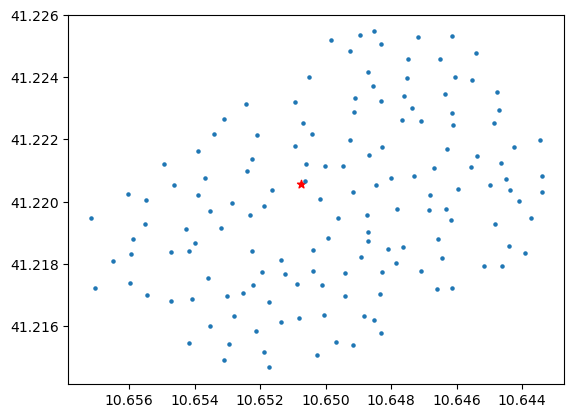

In [56]:
plt.figure(dpi=100)
plt.scatter(test_object.RADEG, test_object.DECDEG, marker="*", c='red')
plt.scatter(points_ra,points_dec, s=5)

plt.gca().invert_xaxis()
#plt.savefig('hm33-d.png', transparent=True)

## Gather values to create DS9 Regions

In [ ]:
regions = {}

In [ ]:
for cat_f in cat_files:
    print(f'\n{cat_f}')
    CAT = pickle.load(open(f'./pickle/{cat_f}','rb'))
    regions = {} # start with a fresh dictionary
    
    for c in CAT:
        #if c!=382: continue
        
        #print(f'Field {c}')
        regions[c] = []
        
        idx,d2d = match_objs(c)
        objs = set(idx)
        d2d = d2d.degree
        
        d2d_idx_tuples = [(d2d[i],idx[i]) for i in range(len(d2d))]
        d2d_idx_df = pd.DataFrame(d2d_idx_tuples, columns=['d2d','idx'])
        
        # get the list of all obj from master_cat which are in the field CAT[c]
        in_field = find_objs_in_field(c,objs)
        #print(in_field)
        #input()
        for obj in in_field:
            obj_ID = obj.ID # extract known object values
            print(f'{obj_ID}...')
            obj_RA = obj.RADEG
            obj_DEC = obj.DECDEG
            
            pts_list = []
            # create a filter for objects in CAT which are closer than delta to their corresponding master_cat object
            filter1 = d2d_idx_df[d2d_idx_df['idx']==obj.name]['d2d'] < 0.006
            # apply the filter
            obj_del = d2d_idx_df[d2d_idx_df['idx']==obj.name][filter1]

            for i in obj_del.index: # iterate through indexes of each nearby point, add to list
                cat_RA = CAT[c][i]['RA']
                cat_DEC = CAT[c][i]['Dec']
                pts_list.append( (cat_RA,cat_DEC) )
            
            # add the data for the object from master_cat
            regions[c].append( (obj_ID,obj_RA,obj_DEC,pts_list) )
    print('Writing...\n')
    # dump data for the current CAT range
    with open(f'./pickle/region_data/{cat_f[:-3]}_region_data.pk','wb') as f_:
        pickle.dump(regions,f_)
        
print('Done!')

<a id="1"></a>
# Main Loop


In [ ]:
matches100 = pickle.load(open('./pickle/matches_delta006_crowding100.pk','rb'))

In [64]:
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [65]:
matches = {}

In [ ]:
for f in cat_files:
    print(f'\n{f}')
    CAT = pickle.load(open(f'./pickle/{f}','rb'))
    
    for c in CAT:
        print(f'Field {c}')
        idx,d2d = match_objs(c)
        objs = set(idx)
        d2d = d2d.degree
        
        d2d_idx_tuples = [(d2d[i],idx[i]) for i in range(len(d2d))]
        
        d2d_idx_df = pd.DataFrame(d2d_idx_tuples, columns=['d2d','idx'])
        
        # get the list of all obj from master_cat which are in the field CAT[c]
        in_field = find_objs_in_field(c,objs)
        delta = 0.006 # the size of the region in which to determine crowding ~21.6 arcsec
        matches[c] = find_closest_match(c, in_field, crowding_limit=250, delta=delta)
        ## add the length of the object list so easy reduction in dataset !!!!!!
        print(in_field)
print('Done!')

In [ ]:
# remove crowded objects and empty fields
empty_fields = []
for c in range(1,407):
    if matches[c] == []:
        empty_fields.append(c)
        matches.pop(c,None)

In [ ]:
with open('./pickle/matches_delta006_crowding250.pk','wb') as f:
    pickle.dump(matches,f)

In [ ]:
with open('./pickle/emptyfields_delta006_crowding250.pk','wb') as f:
    pickle.dump(empty_fields,f)

<a id="2"></a>
# Results